# Utilização da `BibMon` na detecção de eventos indesejados presentes no `3W Dataset`:

O presente notebook surgiu no `HACKTHON` Petrobras 2024' e demonstra como utilizar o software BibMon para detectar de eventos indesejáveis através de sensores marítimos em poços de petróleo.

> Isso é `EnergIA`! :)

Integrantes:

- Laura Magalhães
- Igor Infingardi
- Juliana Hansen
- Helena Lannes


# Importação e leitura da base de dados

Primeiramente, é necessário importar algumas bibliotecas e funções que serão usadas ao longo da análise:

Dica: Se você está usando o VSCode, só rodar um pip install para as bibliotecas! :)

In [1]:
import sys
import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import missingno

sys.path.append('3W')
sys.path.append('BibMon')

A importação dos arquivos será feita, por enquanto, diretamente da pasta do dataset fornecido pelo 3W.

`Aqui será necessário atualizar o PATH de acordo com a localidade do arquivo dataset no seu computador`

Para leitura, utilizaremos a função load_data data abaixo, que lê todos os arquivos dessa pasta, seja em csv ou parquet!

In [2]:
def load_all_data_by_event_and_well(event, well):
    PATH = os.path.join('..', '..', '..', '3W', 'dataset', str(event)) 
    
    # Inicializar a lista de arquivos
    files = []
    
    if os.path.exists(PATH):
        files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]
    else:
        print(f"O caminho {PATH} não existe.")
    
    dfs = {}
    
    if files:  # Verifica se a lista de arquivos não está vazia
        for file in files:
            file_path = os.path.join(PATH, file)
            try:
                fromWell = file.startswith(f"WELL-{well}")
                
                if file.endswith('.csv') and fromWell:
                    # Tentar ler o arquivo CSV com a codificação padrão
                    dfs[file[:-4]] = pd.read_csv(file_path, index_col=0, parse_dates=True).rename_axis(None)
                elif file.endswith('.parquet') and fromWell:
                    # Ler o arquivo Parquet
                    dfs[file[:-8]] = pd.read_parquet(file_path)  # Remover o sufixo '.parquet'
                elif fromWell:
                    print(f"Formato de arquivo desconhecido para {file}.")
            except Exception as e:
                print(f"Erro ao ler {file}: {e}")
    
        print('Data read!\nNumber of instances: ', len(dfs))
    else:
        print("Nenhum arquivo encontrado.")

    return dfs

def load_data_from_file_name(event, fileName):
    PATH = os.path.join('..', '..', '..', '3W', 'dataset', str(event), str(fileName))     

    if os.path.exists(PATH):
        if os.path.isfile(PATH):
            file = PATH
        else:
            print(f"{PATH} não é um diretório.")
    else:
        print(f"O caminho {PATH} não existe.")
    
    dfs = {}
    
    if file.endswith('.csv'):
        # Tentar ler o arquivo CSV com a codificação padrão
        dfs[fileName[:-4]] = pd.read_csv(PATH, index_col=0, parse_dates=True).rename_axis(None)
    elif file.endswith('.parquet'):
        # Ler o arquivo Parquet
        dfs[fileName[:-8]] = pd.read_parquet(PATH)  # Remover o sufixo '.parquet'
    else:
        print(f"Formato de arquivo desconhecido para {file}.")

    return dfs

well = '00001'
dataNormalOperation = load_data_from_file_name(0, 'WELL-00006_20170206210031.parquet')
dataFault = load_data_from_file_name(1, 'WELL-00006_20170731170930.parquet')


No dataset há diversos dados, a função getWellDataAndPlot separa todos os arquivos referentes aos poços (well - objeto de estudo) e lê o poço escolhido através do parâmetro well.

No banco de dados há muitas variáveis com valores vazios ou zerados, caso todos estejam nesse formato, a coluna será filtrada pois uma vez que se mantém sempre constante não agregará na nossa análise.

Algumas variáveis não são nulas o tempo inteiro, alternam entre NaN, 0 e vazio e optamos por filtrá-las manualmente por enquanto através da análise exploratório do banco de dados.

A função também plota subgráficos para cada variável, buscando justamente facilitar essa análise descrita acima.

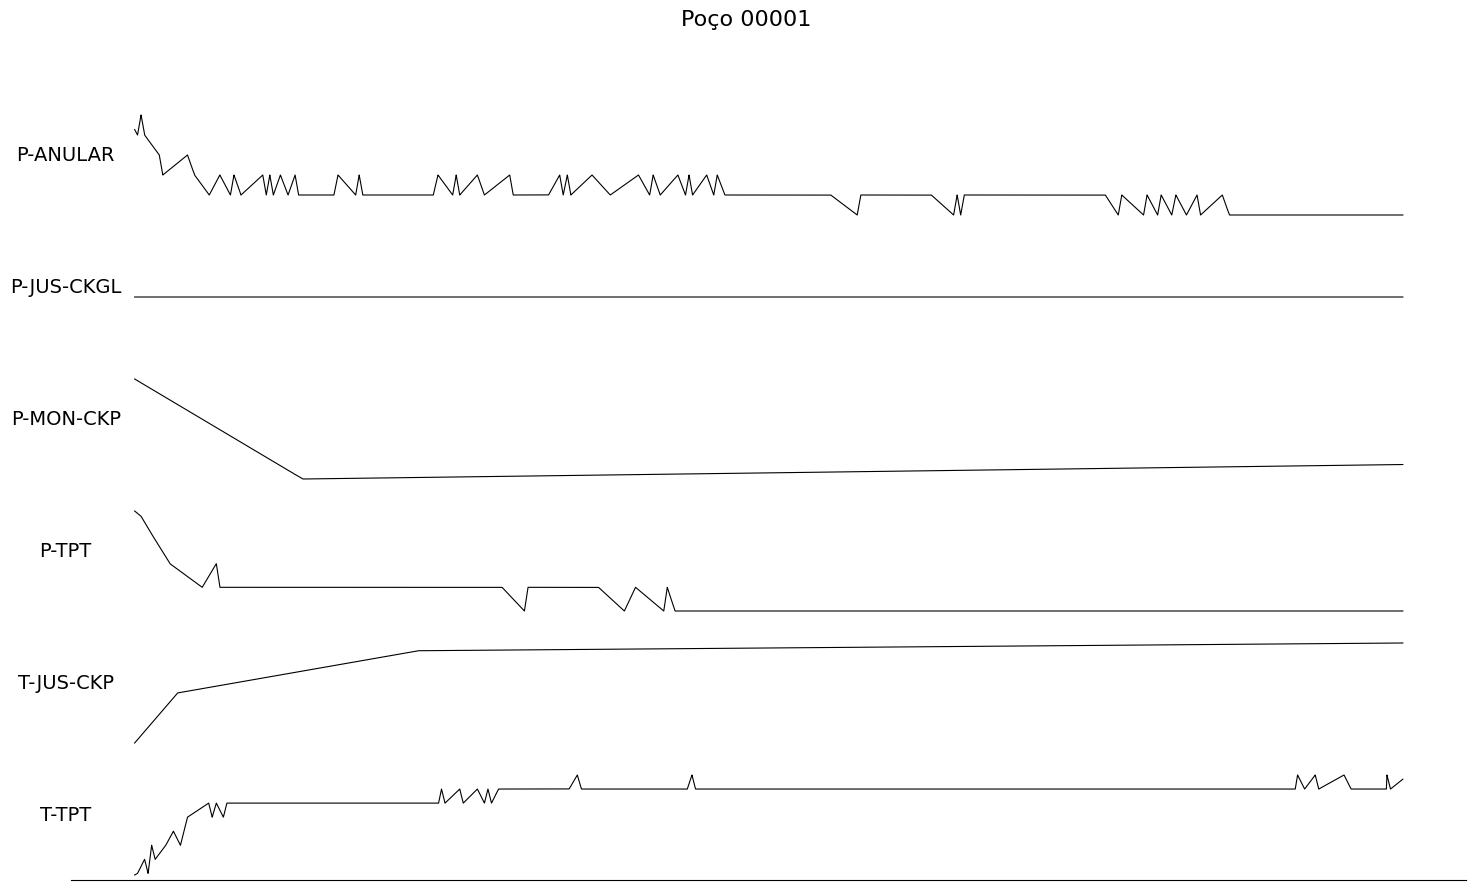

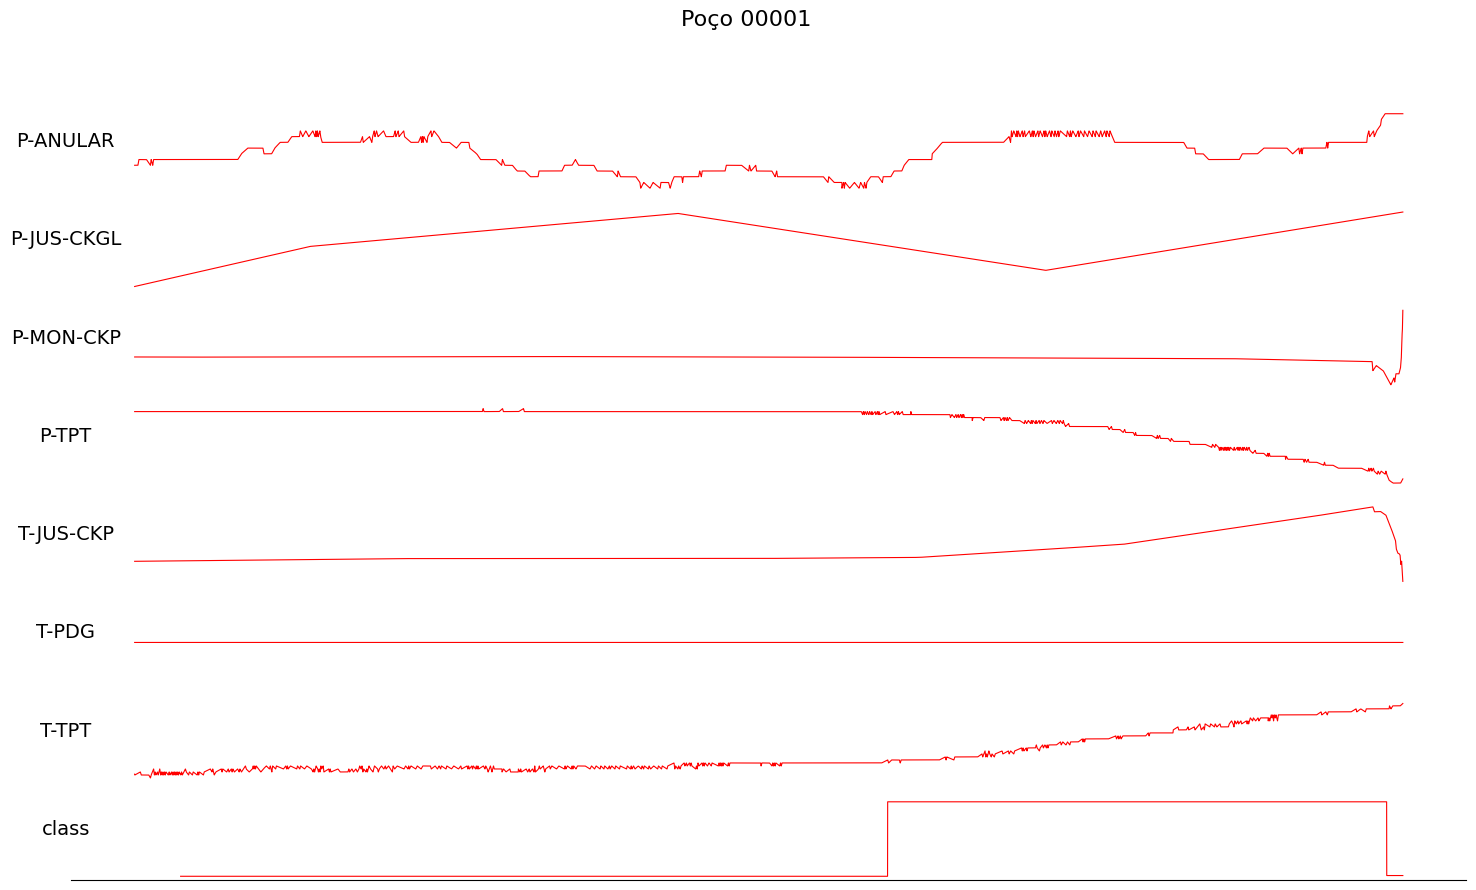

In [3]:
def getWellDataAndPlot(data, color):
    archivesKeys = data.keys()

    filteredByWellData = pd.concat([data[key] for key in archivesKeys]) #Data filtrada para o poço
    
    filteredByWellData = filteredByWellData.apply(pd.to_numeric, errors='coerce')
    # Remover colunas que são todas NaN ou que contêm apenas zeros
    filteredByWellData = filteredByWellData.dropna(axis=1, how='all')  # Remove colunas que são todas NaN
    filteredByWellData = filteredByWellData.loc[:, (filteredByWellData != 0).any(axis=0)]  # Remove colunas que são todas 0
    
    tags = list(filteredByWellData.keys())
    notWantedTags = ['ESTADO-M1', 'ESTADO-SDV-P', 'ESTADO-W1', 'P-PDG']
    tags = [key for key in tags if key not in notWantedTags]

    fig, ax = plt.subplots(len(tags), 1, figsize=(18, 10),sharex=True)
    fig.suptitle(f"Poço {well}", fontsize=16)
    
    for i, tag in enumerate(tags):
        tagData = filteredByWellData[tag].values
        # print(tagData)
        ax[i].plot(tagData, c=color, linewidth=0.8)
        ax[i].set_ylabel(tag, rotation=0, fontsize=14)
        ax[i].set_yticks([])
    
        # Limpar bordas desnecessárias
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
    
        if i < len(tags)-1:  # Oculta os eixos X de todos, exceto o último gráfico
            ax[i].set_xticks([])
            ax[i].spines["bottom"].set_visible(False)
            ax[i].xaxis.set_ticks_position('none')
        else:
            # Rotaciona rótulos no último gráfico para melhor legibilidade
            for label in ax[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
    return filteredByWellData , tags
   

dataNormalOperation, tags0 = getWellDataAndPlot(dataNormalOperation, 'k')    
dataFault, tags1 = getWellDataAndPlot(dataFault, 'r')   

Acima em preto está o comportamento normal de operação e em vermelho está a operação com falha.
A variável class é a chave da determinação da falha, ela indica quando a variável entra no regime transitório de operação (pós-evento não esperado). quando ela está maior que 100, e quando está permanente pós falta, com class mais baixa mas diferente de 0. Em sua operação normal essa variável é 0.

Abaixo há a ordenação das datas. O print está sendo utilizado para verificarmos como essa data está.

In [4]:
dataNormalOperation.index = pd.to_datetime(dataNormalOperation.index)
dataNormalOperation = dataNormalOperation.sort_index()
dataFault.index = pd.to_datetime(dataFault.index)
dataFault = dataFault.sort_index()

Como descrevemos acima, a variável class será utilizada para determinar os regimes de operação do sistemas e detecção de evento anormal.
Assim, encontraremos o início desse evento (quando class > 100) e seu fim, novo estado permanente pós falta.

In [5]:
index_above_100 = dataFault[dataFault['class'] > 100].index[0]

# Agora, filtra a partir desse índice para encontrar o primeiro valor onde class < 100
first_below_100_after = dataFault.loc[index_above_100:][dataFault['class'] == 0]

fault_start = index_above_100

if not first_below_100_after.empty:
    fault_end = first_below_100_after.index[0]
else:
    fault_end = dataFault.index[-1]  # Último valor de dataFault


# Mostra os resultados
print("Primeiro índice onde class > 100:", fault_start)
print("Primeiro índice onde class < 100 após esse valor:", fault_end)

Primeiro índice onde class > 100: 2017-08-01 09:32:22
Primeiro índice onde class < 100 após esse valor: 2017-08-01 20:45:00


C:\Users\Laura\AppData\Local\Temp\ipykernel_8796\2722730644.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_below_100_after = dataFault.loc[index_above_100:][dataFault['class'] == 0]


## Modelagem e detecção das faltas

Para utilizar a `BibMon`, dividiremos nossa base de dados em treinamento, validação e teste. O treinamento gerará nosso modelo e a validação avaliará o modelo e rearranjar o limite de confiança para evitar overfitting, que ocorre quando o modelo está considerando ruídos e outras características que não são sempre constantes e normais.
No teste podemos verificar se o modelo consegue prever a operação normal ou prever uma falta, caso ela aconteça nesse período.


In [6]:
start_train = dataNormalOperation.index[0]
end_train = dataNormalOperation.index[len(dataNormalOperation) // 2]  # Pega o índice no meio
end_validation = dataNormalOperation.index[-1]

start_test = dataFault.index[0]
end_test = dataFault.index[-1]

print(start_train)
print(end_train)
print(end_validation)
print(end_test)


2017-02-06 21:00:31
2017-02-07 00:00:16
2017-02-07 03:00:00
2017-08-01 20:45:00


In [7]:
def train_val_test_split (data, dataTest, start_train, end_train, 
                          end_validation, start_test, end_test, 
                          tags_X = None, tags_Y = None):
    """
    Separates the data into consecutive portions of 
    train, validation, and test, returning 3 DataFrames.
    It can also separate into predictor variables (X) and 
    predicted variables (Y), which in this case will return 6 DataFrames.
        
    Parameters
    ----------
    data: pandas.DataFrame
        Data to be separated.
    start_train: string
        Start timestamp of the train portion.
    end_train: string
        End timestamp of the train portion.
    end_validation: string
        End timestamp of the validation portion.
    start_test: string
        Start timestamp of the validation portion.
    end_test: string
        End timestamp of the test portion.
    tags_X: list of strings
        Variables to be considered in the X set.
    tags_Y: list of strings
        Variables to be considered in the Y set.
    Returns
    ----------                
    : pandas.DataFrames
        Separated data.
    """               
    train_data = data.loc[start_train:end_train]
    validation_data = data.loc[end_train:end_validation].iloc[1:,:]
    test_data = dataTest.loc[start_test:end_test].iloc[1:,:]

    if tags_Y is not None:

        if not isinstance(tags_Y, list): tags_Y = [tags_Y]
        
        train_data_Y = train_data.loc[:,tags_Y]
        validation_data_Y = validation_data.loc[:,tags_Y]
        test_data_Y = test_data.loc[:,tags_Y]

        if tags_X is not None:

            if not isinstance(tags_X, list): tags_X = [tags_X]
            
            train_data_X = train_data.loc[:,tags_X]
            validation_data_X = validation_data.loc[:,tags_X]
            test_data_X = test_data.loc[:,tags_X]

        else:

            dif = train_data.columns.difference(train_data_Y.columns)
            train_data_X = train_data[dif]
            validation_data_X = validation_data[dif]
            test_data_X = test_data[dif]
            
        return (train_data_X, validation_data_X, test_data_X, 
                train_data_Y, validation_data_Y, test_data_Y)
            
    else:
        
        if tags_X is not None:

            if not isinstance(tags_X, list): tags_Y = [tags_X]
            
            train_data = train_data.loc[:,tags_X]
            validation_data = validation_data.loc[:,tags_X]
            test_data = test_data.loc[:,tags_X]           
            
        return (train_data, validation_data, test_data)
            
###############################################################################


def complete_analysis (model, X_train, X_validation, X_test, 
                       Y_train = None , Y_validation = None, Y_test = None,
                       lim_conf = 0.99,
                       f_pp_train = ['remove_empty_variables',
                                     'ffill_nan',
                                     'remove_frozen_variables',
                                     'normalize'],
                       a_pp_train = None,
                       f_pp_test = ['replace_nan_with_values',
                                    'apply_lag',
                                    'normalize'],
                       a_pp_test = None,
                       logy = True, 
                       metrics = None, 
                       X_pred_to_plot = None,
                       count_limit = 1,
                       count_window_size = 0,
                       fault_start = None,
                       fault_end = None):

    from datetime import datetime

    """
    Performs a complete monitoring analysis, with train, validation, and test.

    Parameters
    ----------
    model: BibMon model
        Model to be considered in the analysis.
    X_train: pandas.DataFrame or numpy.array
        Training data X.
    X_validation: pandas.DataFrame or numpy.array
        Validation data X.
    X_test: pandas.DataFrame or numpy.array
        Test data X.
    Y_train: pandas.DataFrame or numpy.array, optional
        Training data Y.
    Y_validation: pandas.DataFrame or numpy.array, optional
        Validation data Y.
    Y_test: pandas.DataFrame or numpy.array, optional
        Test data Y.
    lim_conf: float, optional
        Confidence limit for the detection index.
    f_pp_train: list, optional
        List containing strings with names of functions to be used 
        in pre-processing the train data (the functions are defined in the 
        PreProcess class, in the BibMon_Tools.py file).
    a_pp_train: dict, optional
        Dictionary containing the parameters to be provided
        to each function to perform pre-processing of the train data, in
        the format {'functionname__argname': argvalue, ...}.
    f_pp_test: list, optional
        List containing strings with names of functions to be used 
        in pre-processing the test data (the functions are defined in the 
        PreProcess class, in the BibMon_Tools.py file).
    a_pp_test: dict, optional
        Dictionary containing the parameters to be provided
        to each function to perform pre-processing of the test data, in
        the format {'functionname__argname': argvalue, ...}.
    logy: boolean, optional
        If use logarithmic scale in the SPE plots.
    metrics: list of functions, optional
        Functions for calculating metrics to be displayed in the title of 
        the graph.
    X_pred_to_plot: string, optional
        In case the model is a reconstruction model (i.e., self.has_Y = False),
        indicates which column of X to plot along with the prediction.
    count_limit: int, optional
        Limit of points to be considered in the window 
        for the count alarm to sound.
    count_window_size: int, optional
        Window sizes used in count alarm calculation. 
    fault_start: string, optional
        Start timestamp of the fault.
    fault_end: string, optional
        End timestamp of the fault.
    """               
    fig, ax = plt.subplots(3,2, figsize = (15,12))

    cond_to_plot_pred = (model.has_Y or 
                        ((not model.has_Y) and (X_pred_to_plot is not None)))

    ######## TRAINING ########

    model.fit(X_train, Y_train, 
              f_pp = f_pp_train,
              a_pp = a_pp_train,
              f_pp_test = f_pp_test,
              a_pp_test = a_pp_test,
              lim_conf = lim_conf,
              redefine_limit = False)
                                
    # PLOTTING SPE
                
    model.plot_SPE(ax = ax[0,0], logy = logy)
    ax[0,0].set_title('Training')

    # PLOTTING PREDICTIONS

    if cond_to_plot_pred:
        model.plot_predictions(ax = ax[0,1], train_or_test = 'train', 
                               X_pred_to_plot = X_pred_to_plot,
                               metrics = metrics)

    ######## VALIDATION ########

    model.predict(X_validation, Y_validation, 
                  count_window_size = count_window_size, 
                  redefine_limit = True)

    # PLOTTING SPE

    model.plot_SPE(ax = ax[1,0], train_or_test = 'test', logy = logy)
    ax[1,0].set_title('Validation')

    # PLOTTING PREDICTIONS

    if cond_to_plot_pred:
        model.plot_predictions(ax = ax[1,1], train_or_test = 'test', 
                               X_pred_to_plot = X_pred_to_plot, 
                               metrics = metrics)
        
    ######## TEST ########
        
    model.predict(X_test, Y_test, 
                  count_window_size = count_window_size, 
                  count_limit = count_limit,
                  redefine_limit = False)

    # PLOTTING SPE

    model.plot_SPE(ax = ax[2,0], train_or_test = 'test', logy = logy)
    ax[2,0].set_title('Test')

    if fault_start is not None:
        ax[2,0].axvline(datetime.strptime(str(fault_start),
                                          '%Y-%m-%d %H:%M:%S'), ls = '--')
    if fault_end is not None:
        ax[2,0].axvline(datetime.strptime(str(fault_end),
                                          '%Y-%m-%d %H:%M:%S'), ls = '--')

    # PLOTTING PREDICTIONS

    if cond_to_plot_pred:
        model.plot_predictions(ax = ax[2,1], train_or_test = 'test', 
                               X_pred_to_plot = X_pred_to_plot,
                               metrics = metrics)

        if fault_start is not None:
            ax[2,1].axvline(datetime.strptime(str(fault_start),
                                              '%Y-%m-%d %H:%M:%S'), ls = '--')
        if fault_end is not None:
            ax[2,1].axvline(datetime.strptime(str(fault_end),
                                              '%Y-%m-%d %H:%M:%S'), ls = '--')
        
    fig.tight_layout();




In [8]:
import bibmon

tags = ['ESTADO-W1', 'P-ANULAR', 'P-JUS-CKGL', 'P-MON-CKP', 'P-TPT', 'T-JUS-CKP', 'T-TPT']

print(dataNormalOperation.keys())

(X_train, X_validation, 
 X_test, Y_train, 
 Y_validation, Y_test) = train_val_test_split(dataNormalOperation, dataFault, 
                                                     start_train = start_train, #Início da base de dados
                                                     end_train = end_train, 
                                                     end_validation = end_validation, #Horas antes da falta
                                                     start_test = start_test, #Horas antes da falta
                                                     end_test = end_test, #Fim da base de dados 
                                                     tags_Y = ['T-TPT']) #Essa variável será usada para análise da regressão do modelo

Index(['ESTADO-M1', 'ESTADO-SDV-P', 'ESTADO-W1', 'P-ANULAR', 'P-JUS-CKGL',
       'P-MON-CKP', 'P-TPT', 'T-JUS-CKP', 'T-TPT'],
      dtype='object')


In [9]:
from sklearn.ensemble import RandomForestRegressor  
reg = RandomForestRegressor(n_jobs=-1, random_state=1)

model = bibmon.sklearnRegressor(reg) 

In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

mtr = [r2_score, mean_absolute_error]

CPU times: total: 7.38 s
Wall time: 4.58 s


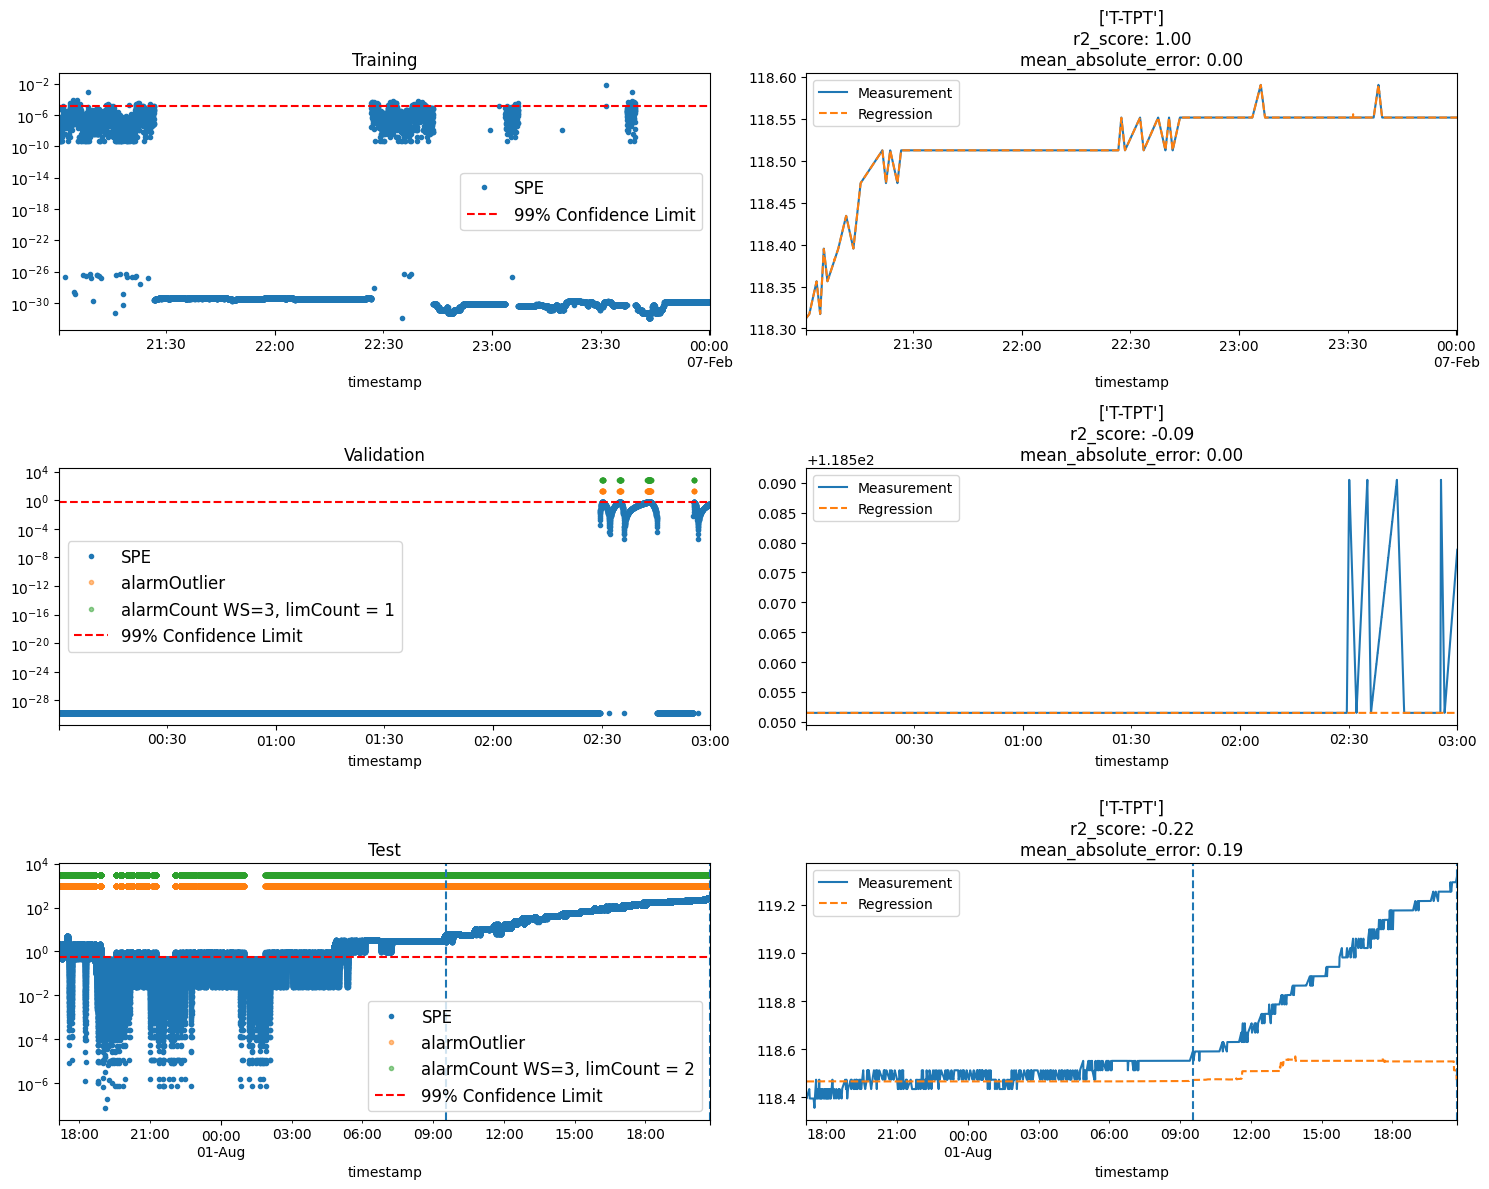

In [11]:
%%time

teste = complete_analysis(model, X_train, X_validation, X_test, 
                         Y_train, Y_validation, Y_test,                    
                         metrics = mtr, count_window_size = 3, count_limit = 2,
                         fault_start = fault_start,
                         fault_end = fault_end)          


T-JUS-CKP    0.715680
P-MON-CKP    0.265649
P-TPT        0.011666
P-ANULAR     0.007004
Name: Importances, dtype: float64

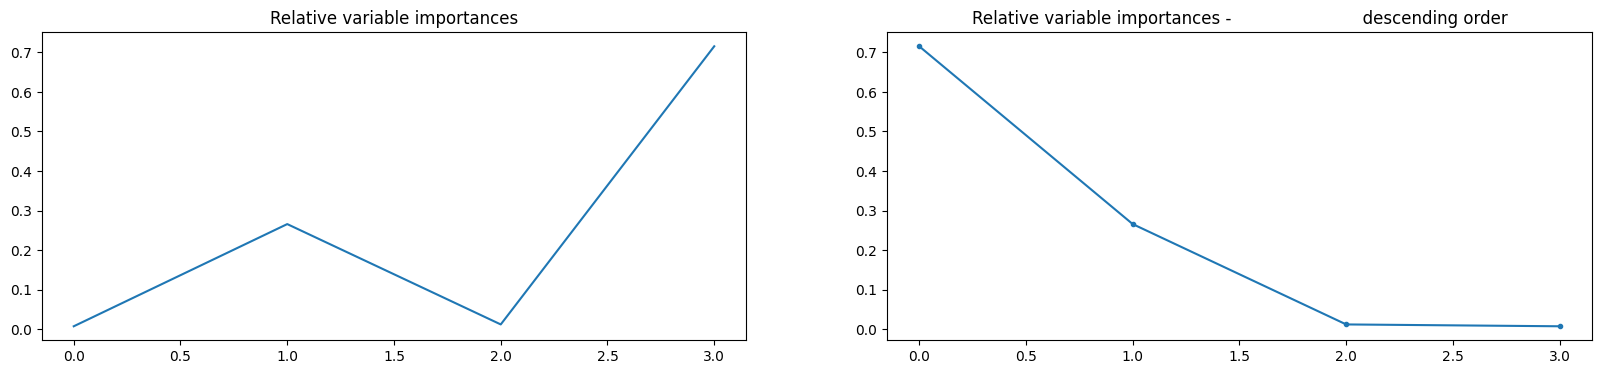

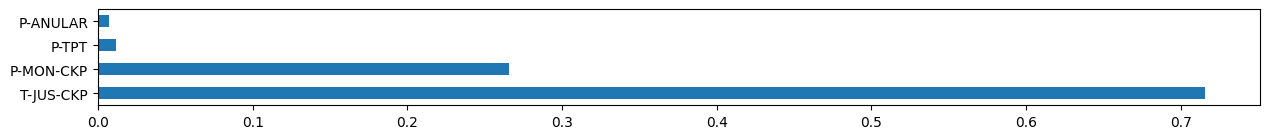

In [12]:
model.plot_importances(n=5)

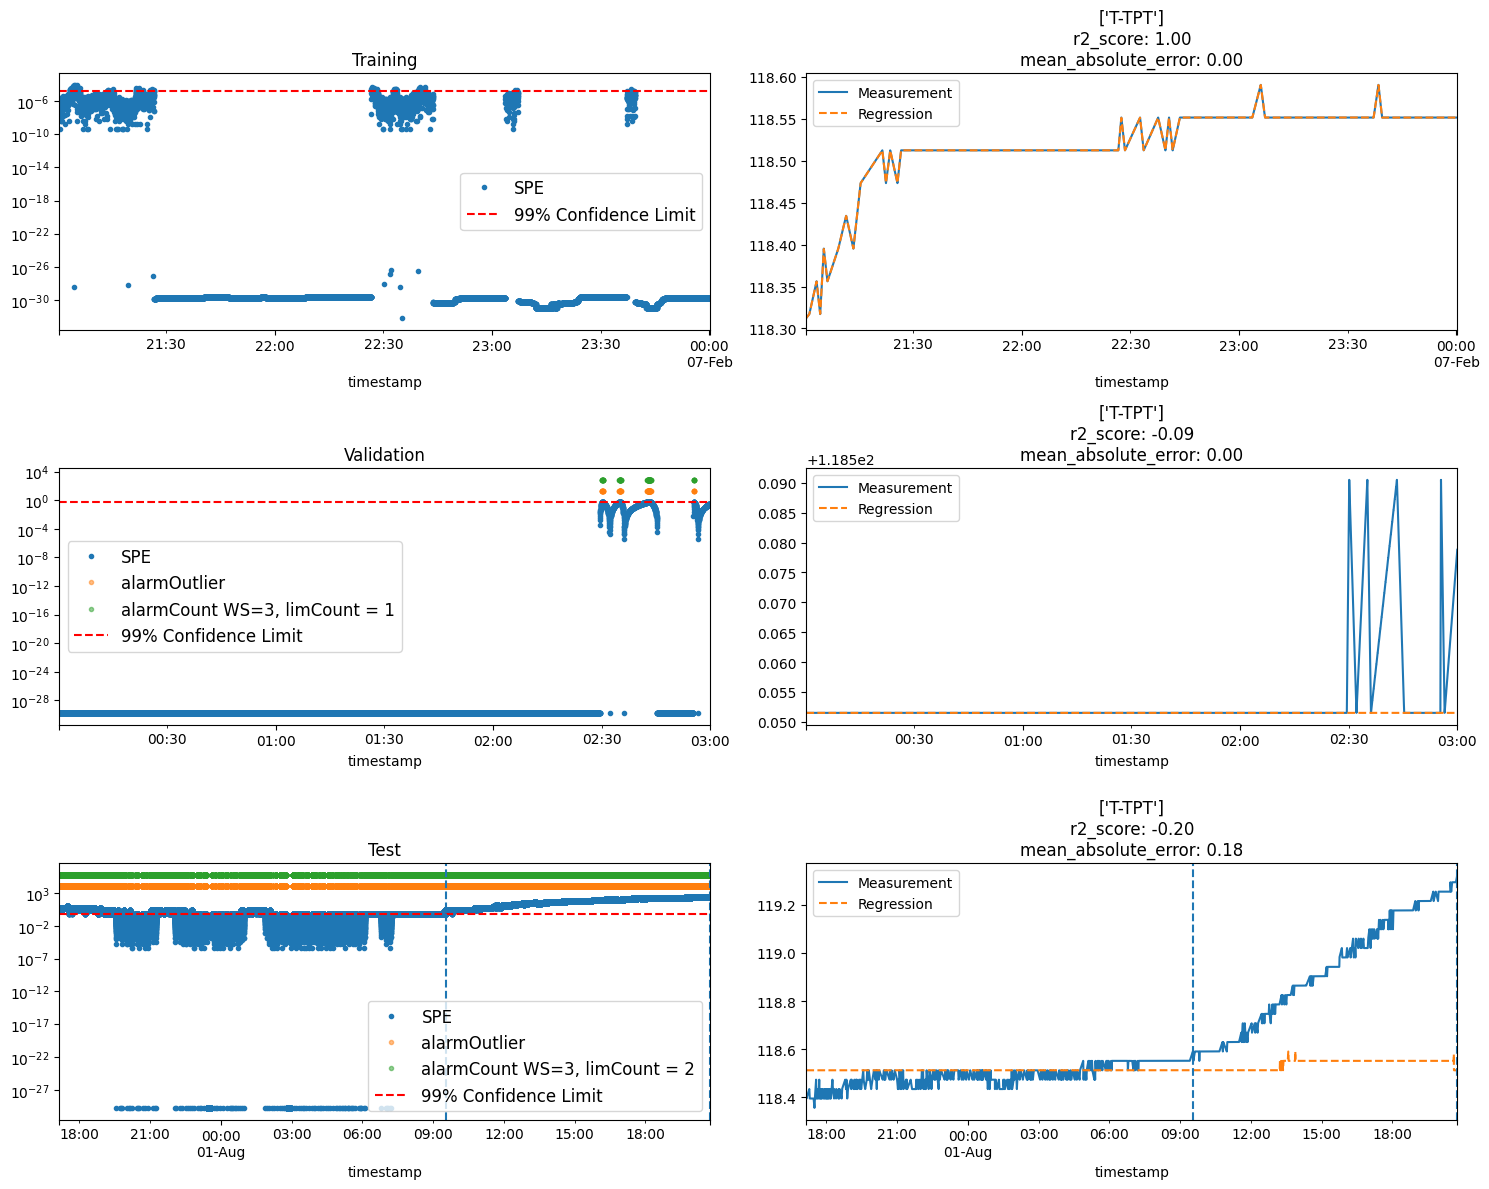

In [13]:
bibmon.complete_analysis(model, X_train['T-JUS-CKP'], X_validation['T-JUS-CKP'], X_test['T-JUS-CKP'], 
                         Y_train, Y_validation, Y_test,                    
                         metrics = mtr, count_window_size = 3, count_limit = 2,
                         fault_start = fault_start,
                         fault_end = fault_end)                       

Comparação de modelos:

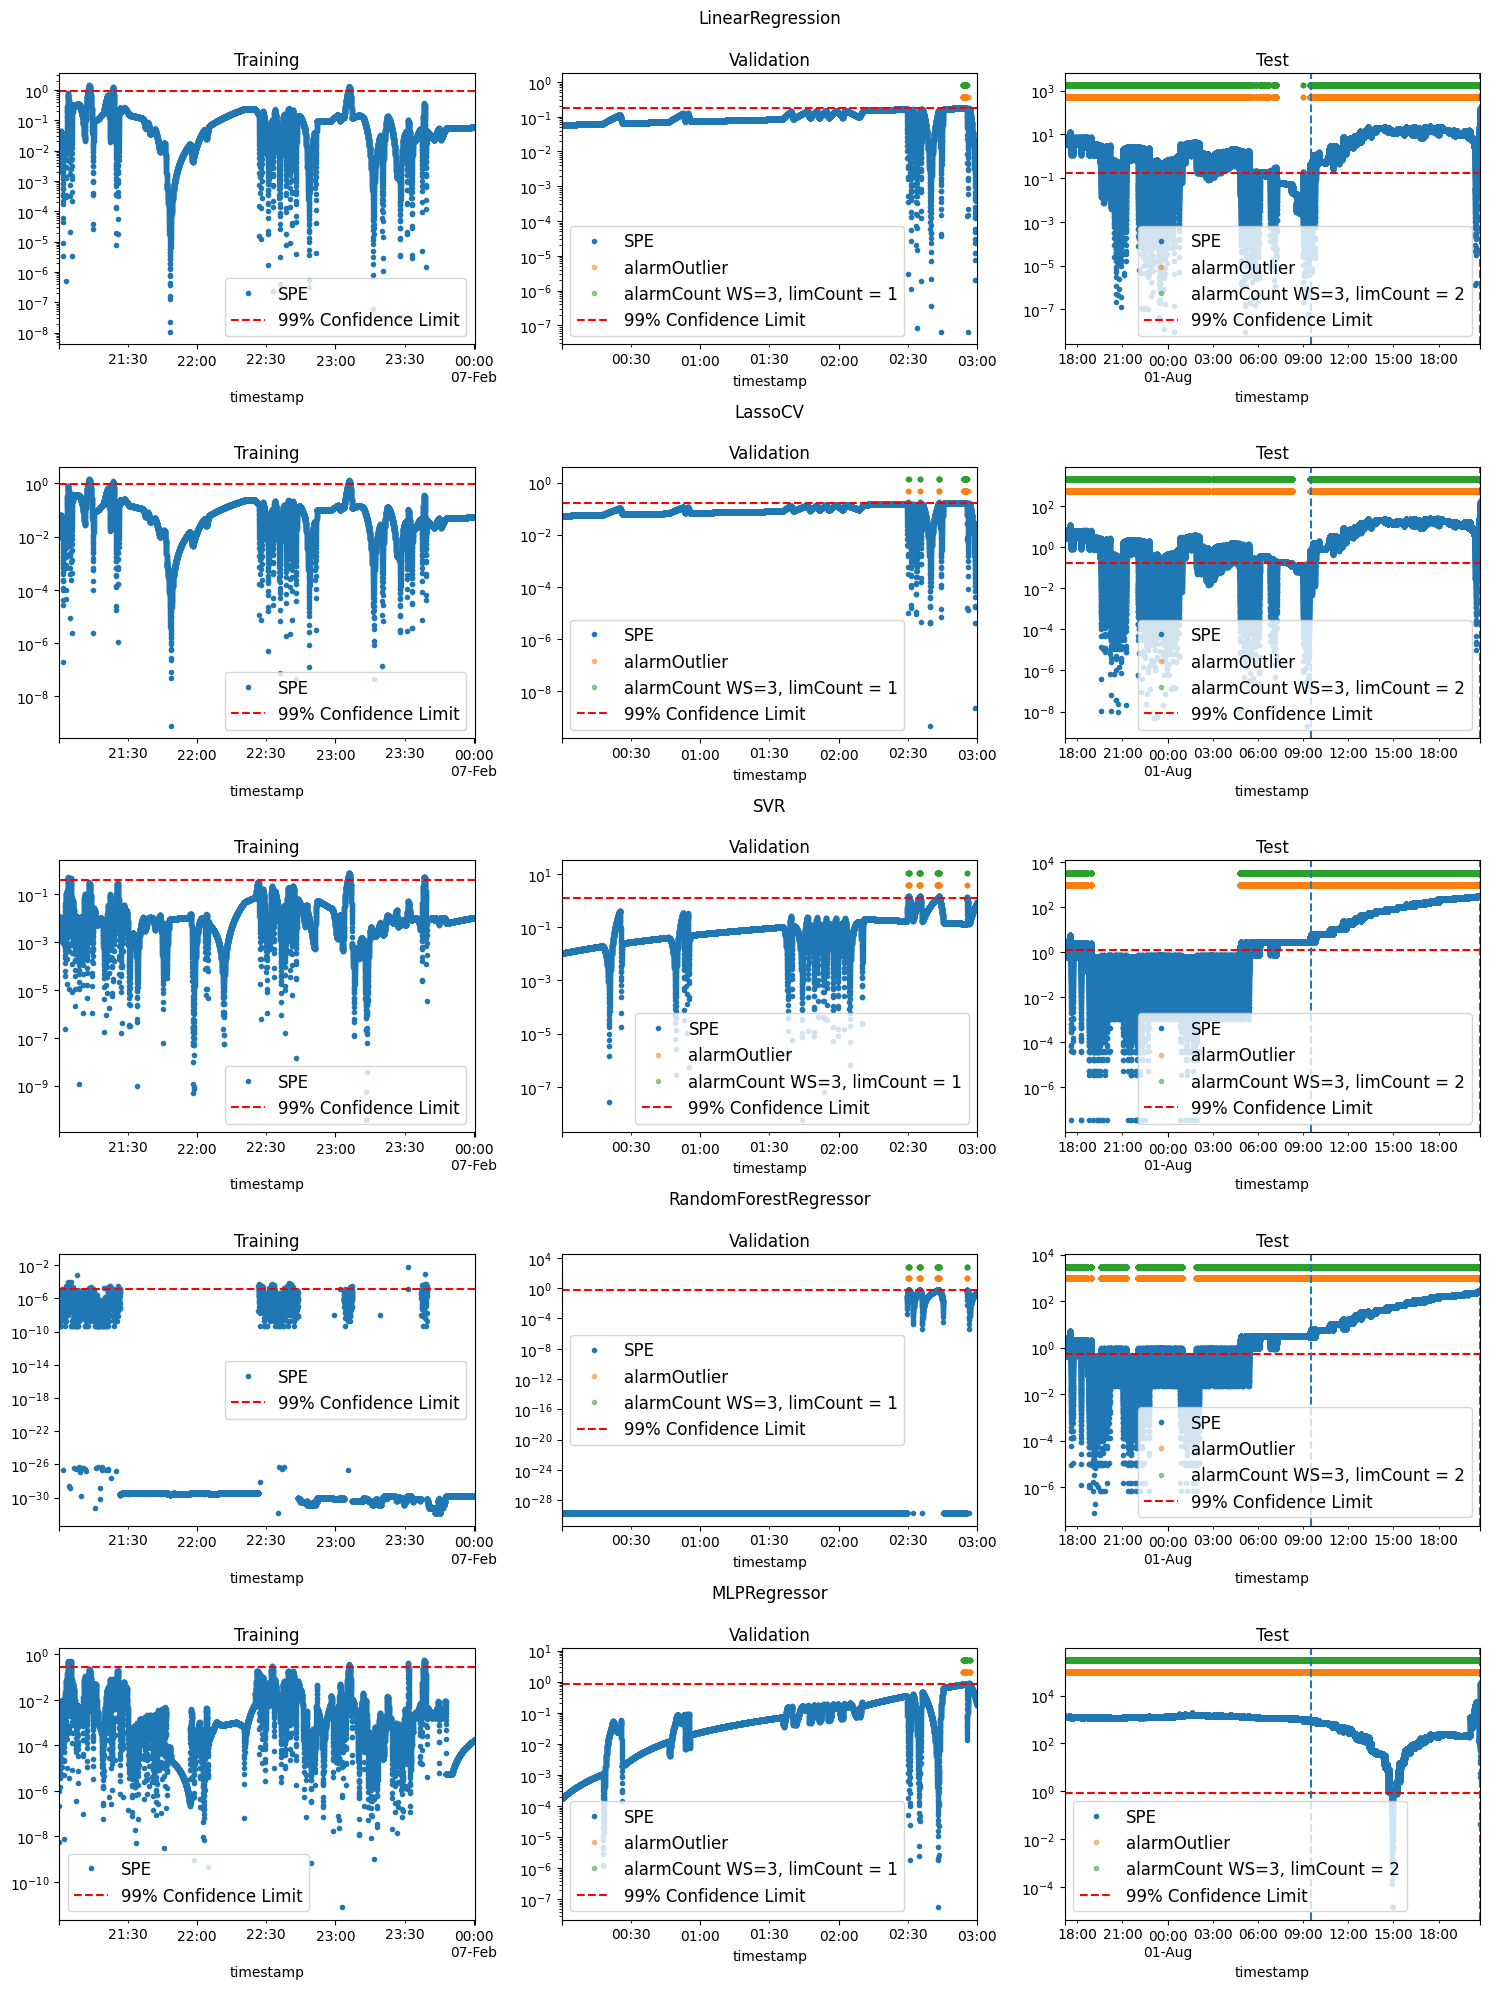

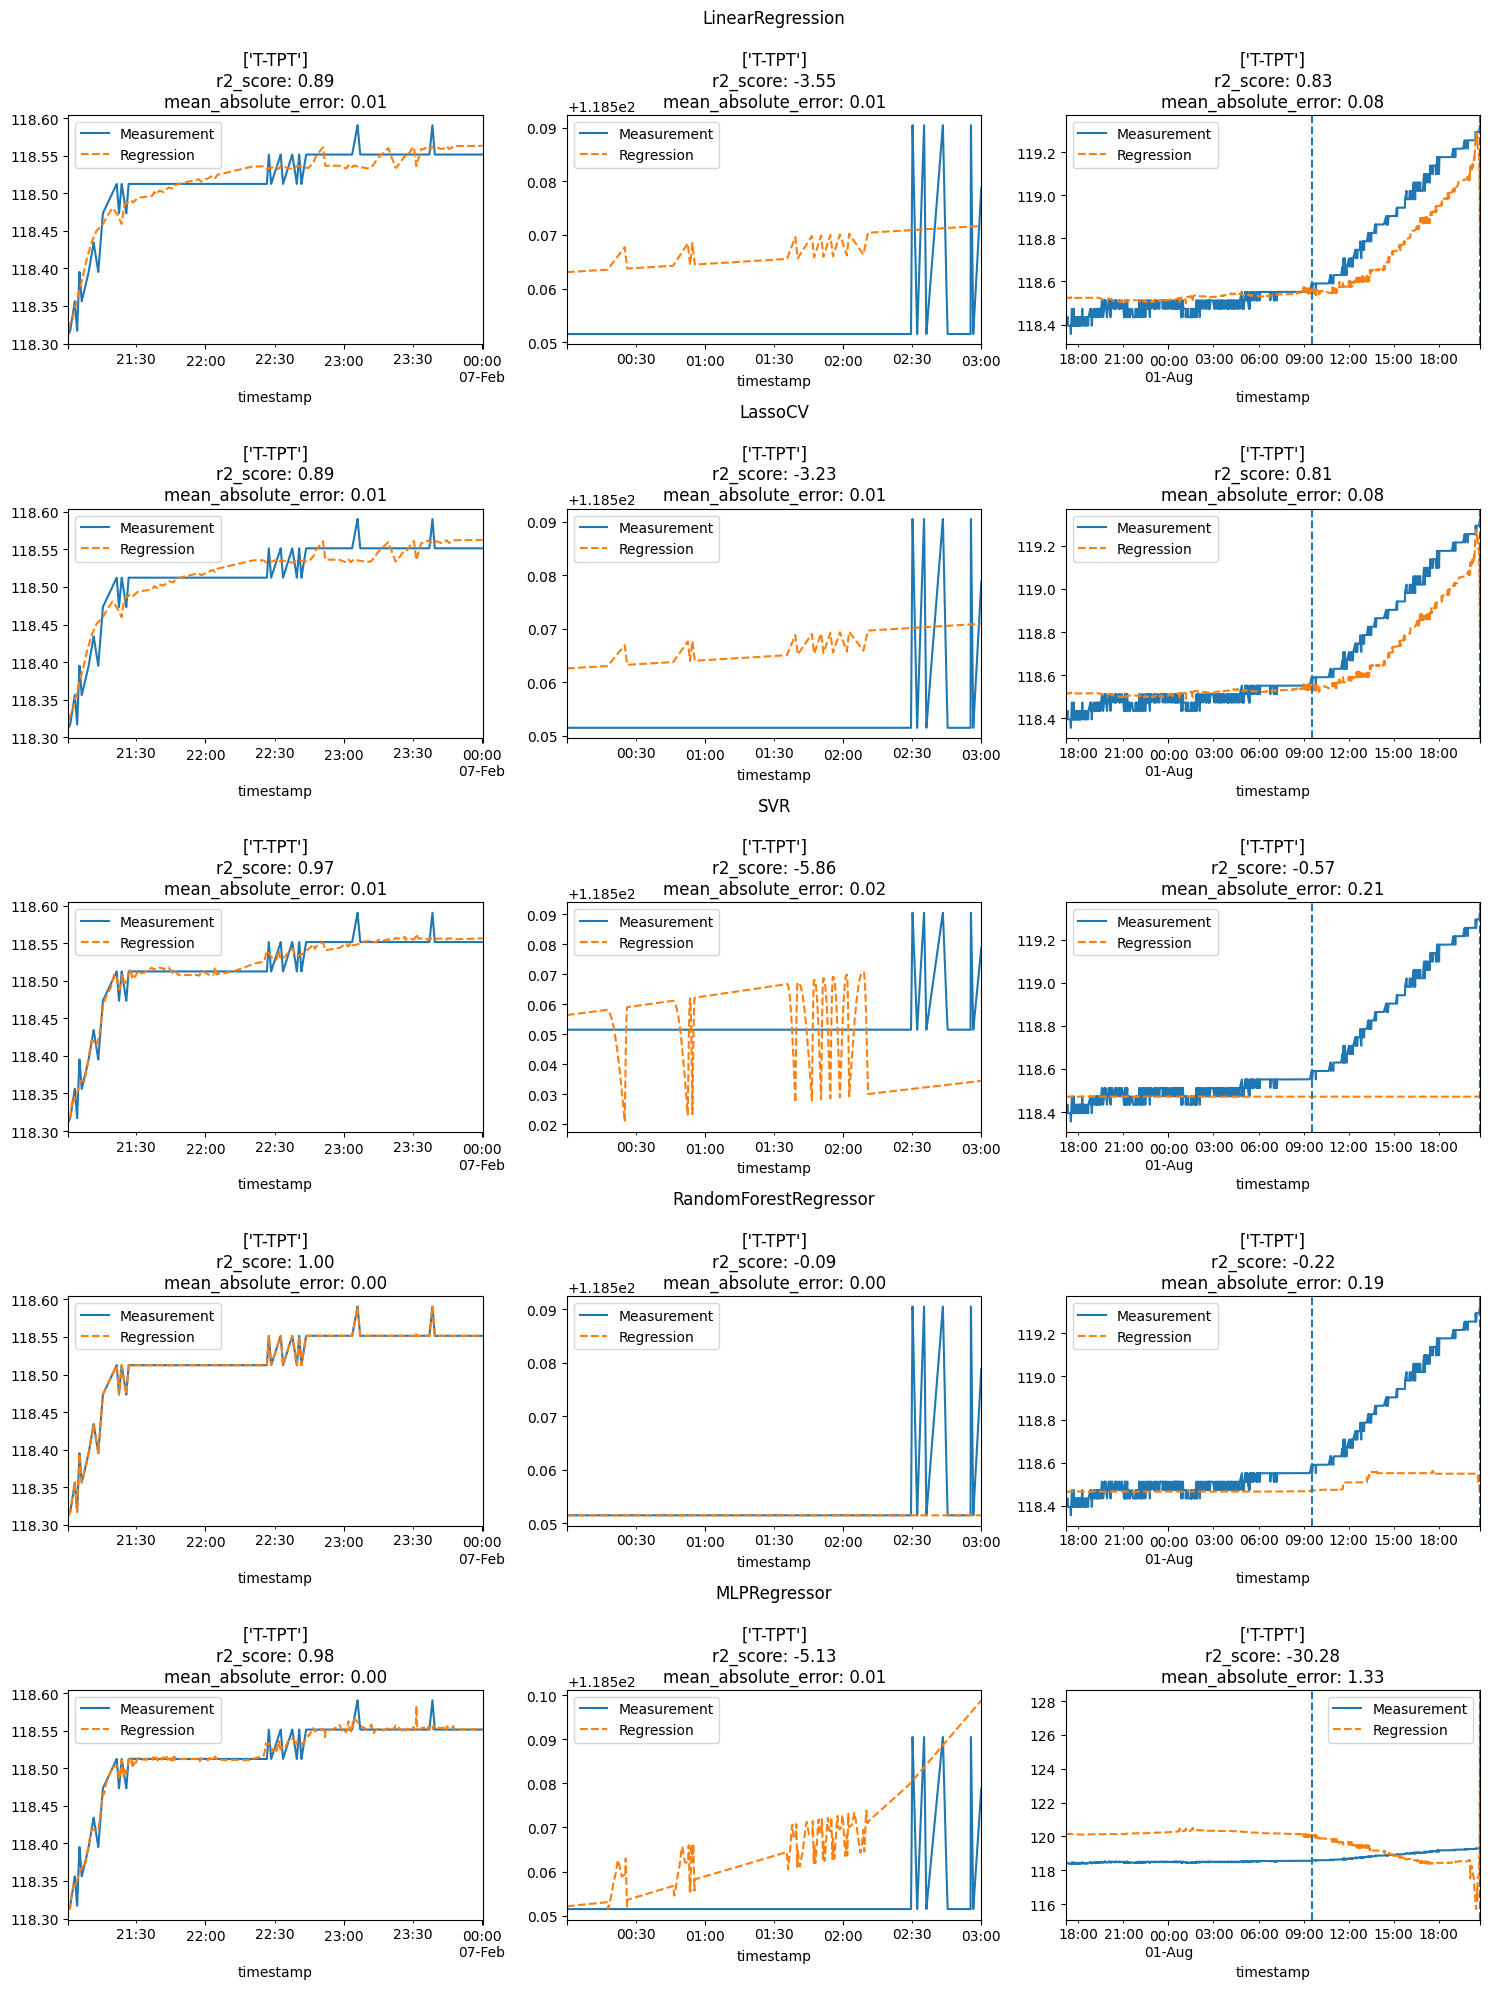

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

sklearn_regs = [LinearRegression(), LassoCV(), SVR(), 
                RandomForestRegressor(n_jobs=-1,random_state=1), 
                MLPRegressor()]

models = [bibmon.sklearnRegressor(reg) for reg in sklearn_regs]

tab_pred, tab_detec, tab_times = bibmon.comparative_table(models, X_train, X_validation, X_test, 
                                                          Y_train, Y_validation, Y_test,                      
                                                          metrics = mtr, count_window_size = 3, count_limit = 2,
                                                          fault_start = fault_start,
                                                          fault_end = fault_end)          

In [16]:
tab_pred.round(3)

Train  Validation    Test
Metrics             Models                                          
mean_absolute_error LassoCV                0.013       0.014   0.084
                    LinearRegression       0.013       0.014   0.082
                    MLPRegressor           0.003       0.014   1.326
                    RandomForestRegressor  0.000       0.002   0.185
                    SVR                    0.006       0.015   0.207
r2_score            LassoCV                0.890      -3.228   0.814
                    LinearRegression       0.890      -3.551   0.828
                    MLPRegressor           0.984      -5.133 -30.279
                    RandomForestRegressor  1.000      -0.092  -0.217
                    SVR                    0.973      -5.856  -0.573

Tabela de alarmes:

In [17]:
tab_detec.round(3)

FDR    FAR
Alarms                        Models                             
alarmCount WS=3, limCount = 2 LassoCV                0.991  0.648
                              LinearRegression       0.987  0.612
                              MLPRegressor           0.994  1.000
                              RandomForestRegressor  1.000  0.497
                              SVR                    1.000  0.303
alarmOutlier                  LassoCV                0.991  0.650
                              LinearRegression       0.987  0.614
                              MLPRegressor           0.994  1.000
                              RandomForestRegressor  1.000  0.498
                              SVR                    1.000  0.304

Tabela de tempos de processamento:

In [19]:
tab_times.round(2)

,Train,Test
LinearRegression,1.34,0.01
LassoCV,10.89,0.01
SVR,526.45,366.12
RandomForestRegressor,78.40,0.92
MLPRegressor,304.59,0.71
